### Content Analysis Community Pages - Inmigration Posts
### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("FB_groups_States_immigration.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(9563, 39)

In [5]:
posts['URL']

0       https://www.facebook.com/groups/79341620735648...
1       https://www.facebook.com/groups/79341620735648...
2       https://www.facebook.com/groups/79341620735648...
3       https://www.facebook.com/groups/79341620735648...
4       https://www.facebook.com/groups/79341620735648...
                              ...                        
9558    https://www.facebook.com/luma.boston/posts/165...
9559    https://www.facebook.com/ElLatinoSanDiego/post...
9560    https://www.facebook.com/ChicagoReligiousLeade...
9561    https://www.facebook.com/LatinoGiving/posts/35...
9562    https://www.facebook.com/LatinoGiving/posts/34...
Name: URL, Length: 9563, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [6]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [7]:
posts.columns

Index(['Unnamed: 0', 'name', 'Page or Account URL', 'List', 'State', 'state',
       'Facebook Id', 'Group Name', 'User Name', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Overperforming Score', 'MessageDescr', 'MessageOnly'],
      dtype='object')

In [8]:
posts["Created"].head(5)

0    2020-08-25 11:26:26 EDT
1    2020-08-25 11:04:22 EDT
2    2020-08-25 10:14:43 EDT
3    2020-08-21 16:52:17 EDT
4    2020-08-20 12:59:43 EDT
Name: Created, dtype: object

In [9]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0      2020-08-25 11:26:26-04:00
1      2020-08-25 11:04:22-04:00
2      2020-08-25 10:14:43-04:00
3      2020-08-21 16:52:17-04:00
4      2020-08-20 12:59:43-04:00
                  ...           
9558   2020-10-11 18:59:23-04:00
9559   2020-10-05 11:11:51-04:00
9560   2020-09-05 18:10:14-04:00
9561   2020-10-23 14:34:54-04:00
9562   2020-09-17 18:20:09-04:00
Name: converted_date, Length: 9563, dtype: datetime64[ns, tzlocal()]

In [10]:
posts['converted_date']=posts['converted_date'].dt.date

In [11]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date


,converted_date,count
0,2020-08-18,117
1,2020-08-19,176
2,2020-08-20,157
3,2020-08-21,97
4,2020-08-22,68
5,2020-08-23,56
6,2020-08-24,133
7,2020-08-25,184
8,2020-08-26,168
9,2020-08-27,128


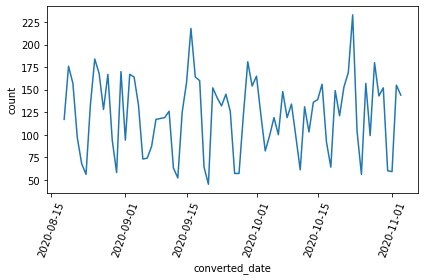

In [12]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [13]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,name,Page or Account URL,List,State,state,Facebook Id,Group Name,User Name,Likes at Posting,...,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Overperforming Score,MessageDescr,MessageOnly,converted_date
0,155,Hispanos unidos en New York (H.U.N.Y),https://www.facebook.com/groups/793416207356486,Latinos+EstadosGroups,New York,New York,793416207356486,Hispanos unidos en New York (H.U.N.Y),NaN,6201.0,...,NaN,Soy un refugiado o asilado: ¿Puedo trabajar ? ...,Migración Soy un refugiado o asilado: ¿Puedo t...,NaN,NaN,0,-44.0,Soy un refugiado o asilado: ¿Puedo trabajar ? ...,Soy un refugiado o asilado: ¿Puedo trabajar ? ...,2020-08-25


In [14]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [15]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [16]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

##  Count posts in general by state

In [17]:

df_count = posts.groupby(['State']).agg({'Facebook Id':'count'}).reset_index() 

df_count.columns = ['State','Posts_Counts']
df_count.sort_values(by=['State'], ascending=True,inplace=True)
df_count.fillna(0, inplace=True)
df_count['Posts_Counts'] = df_count['Posts_Counts'].astype(int)
df_count.head(10)



,State,Posts_Counts
0,Arizona,9
1,Arkansas,3
2,California,467
3,Colorado,11
4,Connecticut,65
5,Florida,3246
6,Georgia,498
7,Illinois,109
8,Indiana,4
9,Iowa,15


In [18]:
#us_states['State'] = us_states['State']
from functools import reduce
data_frames = [df_count, us_states]
missing_states  = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
missing_states.fillna(0, inplace=True)
missing_states['Posts_Counts'] = missing_states['Posts_Counts'].astype(int)
missing_states

,State,Posts_Counts
0,Arizona,9
1,Arkansas,3
2,California,467
3,Colorado,11
4,Connecticut,65
5,Florida,3246
6,Georgia,498
7,Illinois,109
8,Indiana,4
9,Iowa,15


## 3. Which groups are publishing the majority of the content

In [19]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
Venezolanos en Miami,513
LATINOS EN NEW YORK,347
Cubanos en miamifl,320
Venezolanos en La Florida,183
Ecuatorianos en La Florida,173
Venezolanos viviendo en Miami,173
Grupo de Venezolanos Activos en Georgia,170
Peruanos en DC Maryland & Virginia (DMV),166
Marketing Latinos en Atlanta ( USA ),164


In [20]:


republicans = "donald trump|trump|mike pence|nikki haley|john mccain|susan collins|rand paul|chris christie|\
jeff flake|roger stone|george bush|george w. bush|herbert hoover|charles curtis|sarah palin|bill weld|\
rocky de la fuente|joe walsh|mark sanford|herman cain|brad parscale|melania trump|richard nixon|jared kushner|\
ivanka trump|lindsey graham|newt gingrich|rudy giuliani|william barr|mitch mcconnell|gop|republican|\
republicans|republicano|republicanos"


#democrats
democrats = 'joe biden|biden|hillary clinton|kamala harris|michelle obama|bernie sanders|andrew cuomo|tom pérez|\
harry reid|bill clinton|barack obama|adlai stevenson ii|pete buttigieg|michael bennet|deval patrick|andrew yang|\
amy klobuchar|tom steyer|michael bloomberg|elizabeth warren|tulsi gabbard|geraldine ferraro|tony evers|\
nancy pelosi|josh shapiro|democrat|democrats|democratas|democrata'


general_politics = "kanye west|jo jorgensen|spike cohen|howie hawkins|angela walker|don blankenship|gloria la riva|\
brian t. carroll|brock pierce|phil collins|bill hammons|jerome segal|blake huber|mark charles|dario hunter|\
joseph kishore|alyson kennedy|jade simmons|joe mchugh|kyle kopitke|amy coney barrett|ruth bader ginsburg|\
george floyd|oprah winfrey|breonna taylor|geng shuang|philip goldberg|jho low|chris krebs|chris wallace|\
christopher a. wray|louis dejoy|merrick garland|steve scully|susan page|kristen welker|urszula gacek|\
michael georg link|william h. frey|ann selzer|samuel alito|tucker carlson|cynthia stephens|sidney powell|\
shelby pierson|joseph maguire"



posts_democrats = posts.copy()
posts_democrats = posts[posts['MessageDescr'].str.lower().str.contains(democrats   ,na = False)]
print('democrats', posts_democrats.shape)

posts_republicans = posts.copy()
posts_republicans = posts[posts['MessageDescr'].str.lower().str.contains(republicans   ,na = False)]
print('republicans', posts_republicans.shape)

posts_general_politics = posts.copy()
posts_general_politics = posts[posts['MessageDescr'].str.lower().str.contains(general_politics   ,na = False)]
print('general politics', posts_general_politics.shape)


posts_none = posts.copy()
posts_none = posts[~posts['MessageDescr'].str.lower().str.contains(general_politics + '|' + democrats + '|' +republicans ,na = False)]
print('none',posts_none['MessageDescr'].shape)

posts['Link Text'].isna().sum()

democrats (326, 40)
republicans (811, 40)
general politics (31, 40)
none (8670,)


2107

### 6.Filter Posts per each political party
How much each candidate talked about all the topics that Latinx cared about

In [21]:
posts_democrats['MessageDescr'][3:6]

28    Joe Biden aseveró que en "educación, sanidad, ...
33    ¡Un orgullo latino! Vargas fue el estratega na...
43    **La Comisión de #Debates Presidenciales modif...
Name: MessageDescr, dtype: object

In [22]:
posts_democrats.columns

Index(['Unnamed: 0', 'name', 'Page or Account URL', 'List', 'State', 'state',
       'Facebook Id', 'Group Name', 'User Name', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Overperforming Score', 'MessageDescr', 'MessageOnly',
       'converted_date'],
      dtype='object')

In [23]:
df_dem = posts_democrats['State'].value_counts().reset_index()
df_dem.columns = ['State','Count']

In [24]:
df_rep = posts_republicans['State'].value_counts().reset_index()
df_rep.columns = ['State','Count']

In [25]:
df_gen_pol = posts_general_politics['State'].value_counts().reset_index()
df_gen_pol.columns = ['State','Count']

In [26]:
df_gen_info = posts_none['State'].value_counts().reset_index()
df_gen_info.columns = ['State','Count']

In [27]:
from functools import reduce
data_frames = [df_dem, df_rep,df_gen_pol,df_gen_info]
df_all = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
df_all.columns = ['State','Posts_Dem','Posts_Rep', 'Posts_Gen_Pol','Post_Gen_Info']
df_all.sort_values(by=['State'], ascending=True,inplace=True)
df_all.fillna(0, inplace=True)
df_all['Posts_Dem'] = df_all['Posts_Dem'].astype(int)
df_all['Posts_Rep'] = df_all['Posts_Rep'].astype(int)
df_all['Posts_Gen_Pol'] = df_all['Posts_Gen_Pol'].astype(int)
df_all['Post_Gen_Info'] = df_all['Post_Gen_Info'].astype(int)
df_all

,State,Posts_Dem,Posts_Rep,Posts_Gen_Pol,Post_Gen_Info
18,Arizona,1,1,0,8
33,Arkansas,0,0,0,3
2,California,45,85,0,366
31,Colorado,0,0,0,11
25,Connecticut,1,5,0,60
0,Florida,90,220,2,3008
26,Georgia,0,5,0,493
10,Illinois,4,14,0,95
13,Indiana,2,2,0,2
28,Iowa,0,2,0,13


In [28]:
dummy = posts_democrats[posts_democrats['MessageDescr'].str.contains("gop")]
pd.set_option('display.max_colwidth', 400)
dummy['MessageDescr']

8824    Latinos L ❤ V E P R S I D E N T. D O N A L D J T R U M P ! 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 #LATINOSFORTRUMP2020 #TrumpTrain #walkaway #VoteRed2020 #RedWave2020 #fliprgvred #MAGA #Trump2020 #bestpresident #LatinosForTrump #LEXIT #TrumpTrain #VoteRed #DonaldTrump #RepublicanParty #WalkAwayFromDemocrats #creepyjoe2020 #republicangop #KeepTexasRed https://www.facebook.com/344807286197610/posts/59410633...
8825    Be Proud ! Be Loud ! TRUMP 2020🇺🇸 We are climbing in numbers everyday! Latinos are silent No More! We deserve to be heard! Make America Great Again 2020🇺🇸🇺🇸 Get ready because H E R E W E C O M E ! #LATINOSFORTRUMP2020 🇺🇸🇺🇸🇺🇸🇺🇸 #TrumpTrain 🇺🇸❤🇺🇸❤🇺🇸❤ #walkaway #VoteRed2020 #RedWave2020 #fliprgvred #MAGA #Trump2020 #bestpresident #LatinosForTrump #LEXIT #TrumpTrain #VoteRed #DonaldTrump #Republic...
9015    Now that the DNC convention is over, I’d like to discuss some key take-aways: 1. Bill Clinton actually lectured President Trump on Oval Office etiquette. 2. Jimmy Carter - a wo

## FB Groups Political Posts

In [29]:
posts_political =  pd.concat([posts_democrats,posts_republicans,posts_general_politics])

#posts_political = df_posts_state[df_posts_state['MessageDescr'].str.lower().str.contains(democrats + '|' +republicans+ '|' +general_politics, na = False)]
df_political = posts_political['State'].value_counts().reset_index()
df_political.columns = ['State','Count']
df_political

,State,Count
0,Florida,312
1,New York,152
2,California,130
3,Maryland,104
4,Texas,64
5,New Jersey,48
6,Washington,36
7,Illinois,18
8,Virginia,18
9,Ohio,17


## Tokenize words and Clean-up text

In [30]:
content = posts.copy()
content['MessageDescr'].head()

0    Soy un refugiado o asilado: ¿Puedo trabajar ?  Migración Soy un refugiado o asilado: ¿Puedo trabajar ? Por Primera Línea - agosto 25, 2020 0 18 Facebook Twitter WhatsApp ¿Cómo demuestro que estoy autorizado para trabajar en los Estados Unidos? Como refugiado, puede trabajar inmediatamente después de llegar a los Estados Unidos. Cuando se l... Soy un refugiado o asilado: ¿Puedo trabajar ? | Pri...
1    Hoy queremos felicitar a una gran estudiante quien cumplió su sueño de obtener la licencia de conducir con la mejor escuela del estado de New York, LATINOS DRIVING SCHOOL, LA RUTA DIRECTA A TUS SUEÑOS... Para nosotros es muy importante cumplir cada paso junto a cada estudiante para poder verles la felicidad a cada uno y poder retratarlos en nuestras mentes y en nuestros corazon, con el mismo c...
2                                                              SELLO DE EMIGRACIÓN EN COLOMBIA  !!\n🔆 Nos recibirá un gran aroma de cafe con el nuevo selló de Emigracion para muchos será una

In [31]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(9563,)

In [32]:
# Convert to list
data = content.cleanMessage.tolist()

In [33]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [34]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['soy', 'un', 'refugiado', 'asilado', 'puedo', 'trabajar', 'migracion', 'soy', 'un', 'refugiado', 'asilado', 'puedo', 'trabajar', 'por', 'primera', 'linea', 'agosto', 'facebook', 'twitter', 'whatsapp', 'como', 'demuestro', 'que', 'estoy', 'autorizado', 'para', 'trabajar', 'en', 'los', 'estados', 'unidos', 'como', 'refugiado', 'puede', 'trabajar', 'inmediatamente', 'despues', 'de', 'llegar', 'los', 'estados', 'unidos', 'cuando', 'se', 'soy', 'un', 'refugiado', 'asilado', 'puedo', 'trabajar', 'primera', 'linea', 'nyc'], ['hoy', 'queremos', 'felicitar', 'una', 'gran', 'estudiante', 'quien', 'cumplio', 'su', 'sueno', 'de', 'obtener', 'la', 'licencia', 'de', 'conducir', 'con', 'la', 'mejor', 'escuela', 'del', 'estado', 'de', 'new', 'york', 'latinos', 'driving', 'school', 'la', 'ruta', 'directa', 'tus', 'suenos', 'para', 'nosotros', 'es', 'muy', 'importante', 'cumplir', 'cada', 'paso', 'junto', 'cada', 'estudiante', 'para', 'poder', 'verles', 'la', 'felicidad', 'cada', 'uno', 'poder', 'retr

#### Creating Bigram and Trigram Models

In [35]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['soy', 'un', 'refugiado_asilado_puedo', 'trabajar', 'migracion', 'soy', 'un', 'refugiado_asilado_puedo', 'trabajar', 'por', 'primera', 'linea', 'agosto', 'facebook', 'twitter', 'whatsapp', 'como', 'demuestro', 'que', 'estoy', 'autorizado', 'para', 'trabajar', 'en', 'los', 'estados_unidos', 'como', 'refugiado', 'puede', 'trabajar', 'inmediatamente', 'despues', 'de', 'llegar', 'los', 'estados_unidos', 'cuando', 'se', 'soy', 'un', 'refugiado_asilado_puedo', 'trabajar', 'primera', 'linea', 'nyc']


## Remove Stopwords, Make Bigrams and Lemmatize

In [36]:
#import nltk
#nltk.download('stopwords')
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [37]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [38]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#!python3 -m spacy download es_core_news_sm
#!python -m spacy download es
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [39]:
print(data_words_nostops[1:2])

[['hoy', 'queremos', 'felicitar', 'gran', 'estudiante', 'cumplio', 'sueno', 'obtener', 'licencia', 'conducir', 'mejor', 'escuela', 'new', 'york', 'latinos', 'driving', 'school', 'ruta', 'directa', 'suenos', 'importante', 'cumplir', 'cada', 'paso', 'junto', 'cada', 'estudiante', 'poder', 'verles', 'felicidad', 'cada', 'poder', 'retratarlos', 'mentes', 'corazon', 'mismo', 'corazon', 'damos', 'dia', 'dia', 'mejor', 'final', 'recibir', 'amor', 'agradecimiento', 'llena', 'fuerza', 'seguir', 'adelante', 'apoyando', 'toda', 'comunidad', 'da', 'plena', 'certeza', 'haciendo', 'trabajo', 'correcto', 'aun', 'haz', 'comenzado', 'proceso', 'esperas', 'momento', 'activemos', 'podamos', 'seguir', 'avanzando', 'gran', 'equipo', 'medio', 'adversidades', 'puedes', 'reservar', 'cupos', 'cualquiera', 'servicios', 'traves', 'pagina', 'facebook', 'dejandonos', 'mensaje', 'nombre', 'numero', 'servicio', 'requieres', 'asistentes', 'contactara', 'puedes', 'llamarnos', 'directamente', 'oficina', 'gusto', 'atend

## Bag of Words

In [40]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [41]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [42]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [43]:
final_dict.most_common(1000)

[('legal', 1797),
 ('abogar', 1667),
 ('hacer', 1613),
 ('inmigrante', 1458),
 ('frontero', 1301),
 ('ano', 1282),
 ('hoy', 1244),
 ('casar', 1226),
 ('tambien', 1099),
 ('procesar', 1095),
 ('trump', 1083),
 ('poder', 1074),
 ('personar', 1014),
 ('trabajar', 997),
 ('partir', 942),
 ('inmigracion', 938),
 ('decir', 884),
 ('servicio', 879),
 ('unir', 860),
 ('nuevo', 827),
 ('ley', 827),
 ('asilar', 807),
 ('solo', 752),
 ('visar', 725),
 ('familiar', 721),
 ('llamar', 716),
 ('dar', 695),
 ('preguntar', 694),
 ('migratorio', 683),
 ('familia', 678),
 ('vivir', 653),
 ('mejor', 639),
 ('ayudar', 628),
 ('consultar', 627),
 ('contar', 596),
 ('conocer', 576),
 ('tramitar', 575),
 ('llegar', 574),
 ('estatus', 566),
 ('mexico', 563),
 ('hora', 551),
 ('indocumentado', 542),
 ('tiempo', 542),
 ('covid / coronavirus', 529),
 ('querer', 527),
 ('programar', 516),
 ('seguro', 515),
 ('president / presidente', 513),
 ('octubre', 507),
 ('formulario', 501),
 ('importante', 500),
 ('noticiar'

In [44]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [45]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
#print(bow_df)

In [46]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [47]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
legal,3.018202
abogar,3.065734
frontero,3.142002
hoy,3.246077
casar,3.282299
hacer,3.303003
inmigracion,3.425242
inmigrante,3.432359
tambien,3.445541
ano,3.467493


In [48]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [49]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv("outlets_tfidf.csv")

In [50]:
df

,tfidf
autorizar,0.202628
despues,0.165082
inmediatamente,0.220999
linear,0.385708
llegar,0.138235
nyc,0.264259
primero,0.293820
refugiado_asilado,0.221738
refugiar,0.201351
trabajar,0.633547


In [51]:
word = df.index[1]
content["lowercase"] = content['cleanMessage'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')
word_messages.to_csv(word + "_messages.csv")
word_messages

,unique_messages,counts
0,"la dignidad del pueblo latino no se compra con 13 billones sr. presidente. despues de insultar a los hijos e hijas de daca, despues de separar familias en la frontera, despues hacernos esperar por ayudas despues de huracanes o temblores de tierra o despues de echar hacia atras regulaciones ambientales sobre las cenizas de carbón y calidad de agua, que afecta mayormente a nuestra clase menos pr...",2
1,"hola alguien sabe si puedo viajar a argentina? soy residente de usa, pero me cancelaron el pasaje de united airlines para el 03 de octubre, porque supuestamente estaban cerradas las fronteras, y despues veo gente que viene a miami desde argentina sin problema, alguien tiene idea si puedo viajar? y por que aerolinea? mil gracias",1
2,estimados compatriotas: sinceramente pido disculpas de antemano como lo hizo vizcarra por a veces extenderme algo en los temas que pocas veces trato en mi muro. temas por demas inadecuados en redes sociales donde solo se habla de cosas triviales pero de mucho interes para muchos... como que modelo de egg le saco la vuelta al jugador x … o con quien fue el ampay de los urracos esta semana… pido...,1
3,"🚨ventas por live chamarras, botas, sacos, tenis, todo para tu outfit de invierno❗🚨 entra a la rifa especial 6 meses de aniversario de stylish latina y ganate un outfit elegido por la estilista de modas nancy rosales (osea yo)❗❗❗ asegurate que ya le diste like a la pagina, etiqueta a 3 amigas y comparte en tu muro en forma publica y etiquetanos. rifa solo en el en vivo de 2 collares de perla❗❗...",1
4,"🚨ventas por live accesorios unicos y bellos❗🚨 entra a la rifa especial 6 meses de aniversario de stylish latina y ganate un outfit elegido por la estilista de modas nancy rosales (osea yo)❗❗❗ asegurate que ya le diste like a la pagina, etiqueta a 3 amigas y comparte en tu muro en forma publica y etiquetanos. rifa solo en el en vivo de 2 collares de perla❗❗❗ compartiendo e interactuando (comen...",1
5,"denis manuel peralta hernández , este sujeto es de ocotal nueva segovia, fue el torturador y asesino en el ejército popular sandinista en los años 80, en el 91 o 92 se rearmo c9n otros delincuentes que tenían un buzón de armas escondidos y asesino unos campesinos en la comunidad de orosi en el municipio de san fernando nueva segovia, este delincuente despues negocio con acnur para desarmarse ...",1
6,la verdad detrás de los demócratas y sus tendencias comunistas socialistas. el movimiento de izquierda que kamala harries se siente orgullosa y dice que no van a parar de protestar ni antes ni despues de las elecciones seguirán negando los demócratas que no llevan corrientes comunistas socialistas y por allí quieren encaminar el país? cuál es el vínculo de el “ black lives matter y nicolas mad...,1
7,**no tengo derechos de musica ni de cualquier sonido que se escuche de fondo** 💵💰loteria y bingo chicas y chicos! \n\ndinámica de hoy:\n\n🔵comparte esta video en modo publico en tu muro ( comenta “compartido” para mirar el badge de distribuidor de contenido facebook) y entras a una rifa gratis gratis. \n\n🔵manda mensaje 👋🏻si eres nueva (o) para contactarte en caso de resultar ganadora.\n\n🔵 ...,1
8,"puerto rico seguira esperando los billones, como los anti-inmigrantes seguiran esperando su muro y que mexico pague por el, tambien los anti-obamacare seguiran esperando despues de 3 anos que anulen obamacare. este tipo es falso y a sus seguidores les gusta ser enganados, asi les pongas un audio de su lider mintiendo, asi lo vean no pudiendo tomar un vaso de agua con una mano, asi lo vean habl...",1
9,"aceptenlo peruanos conservadores por trump, su presidente se rodeo de gente sin escrupulos capaz de todo por ganar. bannon, un racista confeso, hasta ha robado 25 millones de dolares de muchos racistas que se ""mocharon"" para construir el muro. que paso? se quedaron mudos y perdieron la sonrisa? no se preocupen que no van a recuperar la sonrisa asi de facil porque en otras noticias, una corte f..

### Repeated messages

In [52]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)
results.shape
#results.to_csv("mostpopularNewsMedia.csv")

(5178, 11)

In [53]:
results.sort_values(by='Total Interactions',ascending=False).head(20)

Counts  \
MessageDescr                                                                                                                                                                                                                                                                                                                                                                                                     Link                                                                                                                                                                                                                                                                 
Join Orlando and Andrea on Wednesday at 11:00 AM as they speak with Senator Pete Flores, who is running for re-election in Texas Senate District 19, which is composed of all or parts of 17 counties running from Bexar west to Brewster and encompassing a long stretch of border with Mexico. A former leader of Texas Parks and Wildlife’s statewide law enforcement division with strong ties to South a... https://www.facebook.com/TLCforTexas/photos/a.842063062473716/3833693883310604/?type=3                                                                                                                                                                           1   
A fellow patriot and Latino for President Trump is being bombarded by crazy leftists. We need to stick together and help each other out. Go show him some love! 🇺🇸🇺🇸🇺🇸 I am a,\nMexican American Patriot \nWho understands the color of my skin, my last name and the place where my ancestors were born DONT predetermine my POLITICAL VALUES.\nI am a #hispanic in favor of #prolife, #patriotism, standing... https://www.facebook.com/photo.php?fbid=3558200770898884&set=p.3558200770898884&type=3                                                                                                                                                                           1   
🇻🇪🇺🇲 Marisol Román llegó a Estados Unidos hace 10 años con su familia. Natal de Valencia, en el estado Carabobo, la joven venezolana se propuso sobresalir en sus estudios. Por ello, la NASA le ofreció una beca que cubre sus estudios de doctorado y un proyecto de investigación en esa agencia espacial. . Román estudió Ingeniería Eléctrica en Florida International University. Allí se enamoró del á... https://www.facebook.com/photo.php?fbid=10224616661182964&set=gm.3268571359915293&type=3                                                                                                                                                                         1   
 President Trump has overseen the strictest immigration policy of any president in modern political times, and Hispanic community leaders have said that will kill his chances to attract Hispanic voters. Trump poised to win more Hispanic votes in spite of strict immigration policy https://t.co/Ie6lXQFVVP                                                                                                 https://t.co/Ie6lXQFVVP                                                                                                                                                                                                                                          2   
Acabo de leer un escrito formidable de un americano nacido en USA .y Dice así: De las dos caras que tenemos para elegir en este Noviembre 3, si algo les ofende, lo siento, yo puedo manejarlo porque no se trata de mi, se trata de la mas dramática encrucijada a la que nos hemos enfrentado en un siglo. Gracias por sus indulgencias. Primero veamos a Joe Biden, en 1973 ingresa en la política, siete ... https://www.facebook.com/photo.php?fbid=10224296434301258&set=gm.847262279411941&type=3                                                                                                                                                                          1   
This looks e

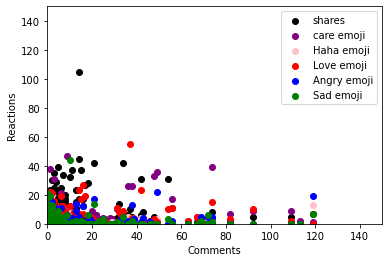

In [54]:
results.reset_index()
plt.xlim(0,150)
plt.ylim(0,150)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [55]:


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 5), (10, 2)]]


[[('autorizar', 1),
  ('despues', 1),
  ('inmediatamente', 1),
  ('linear', 2),
  ('llegar', 1),
  ('nyc', 1),
  ('primero', 2),
  ('refugiado_asilado', 1),
  ('refugiar', 1),
  ('trabajar', 5),
  ('unir', 2)]]

## Buiding the Topic Model

In [56]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [57]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.051*"denunciar" + 0.049*"centro" + 0.045*"posible" + 0.044*"tiempo" + '
  '0.044*"necesitar" + 0.038*"permitir" + 0.035*"vida" + 0.034*"detencion" + '
  '0.031*"pedir" + 0.030*"medicos"'),
 (1,
  '0.192*"ayudar" + 0.182*"mexico" + 0.140*"publicar" + 0.047*"continuo" + '
  '0.045*"vestir" + 0.030*"fin" + 0.027*"lunes" + 0.022*"periodo" + '
  '0.018*"largar" + 0.017*"comentar"'),
 (2,
  '0.124*"vivir" + 0.116*"detenido" + 0.064*"operativo" + 0.061*"local" + '
  '0.049*"redar" + 0.032*"anterior" + 0.027*"campana" + 0.027*"arresto" + '
  '0.022*"noche" + 0.021*"estudiante"'),
 (3,
  '0.096*"tratar" + 0.091*"migrante" + 0.067*"indicar" + 0.057*"representante" '
  '+ 0.050*"correar" + 0.039*"liderar" + 0.028*"menor" + 0.025*"cursar" + '
  '0.025*"nivel" + 0.024*"clase"'),
 (4,
  '0.188*"casar" + 0.084*"ee_uu" + 0.082*"llevar" + 0.077*"utilizar" + '
  '0.036*"sexual" + 0.029*"muerte" + 0.026*"congreso" + 0.026*"limitar" + '
  '0.025*"resultar" + 0.023*"ilegal"'),
 (5,
  '0.118*"habl

## Compute Model Perplexity and Coherence Score

In [58]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -17.568576356345645

Coherence Score:  0.3314412323763823


## Visualize the topics-keywords

In [59]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.271021  0.275074       1        1  20.714159
7      0.169769 -0.024174       2        1  11.102833
8      0.180365 -0.246863       3        1   7.817126
17     0.135540  0.205287       4        1   7.050894
9      0.094251 -0.146612       5        1   6.849827
16     0.117051 -0.064611       6        1   6.230385
15     0.020958 -0.015641       7        1   4.995783
10     0.096256 -0.063684       8        1   4.931308
0      0.035395 -0.032409       9        1   4.574247
4     -0.052079 -0.020553      10        1   3.407997
2      0.013493 -0.054117      11        1   3.200796
5     -0.078492  0.005417      12        1   3.174367
13    -0.091080  0.004348      13        1   2.968015
14    -0.106931 -0.001145      14        1   2.873208
6     -0.117575  0.015436      15        1   2.389076
1     -0.100225  0.025177      16        1   2.142600
19    -0.153079  0.033003      17        1   1.912516
3     -0.109586  0.042092      18        1   1.789398
18    -0.162486  0.025480      19        1   1.013434
12    -0.162567  0.038496      20        1   0.862029, topic_info=                          Term         Freq        Total Category  logprob  \
223                      legal  3602.000000  3602.000000  Default  30.0000   
222                 inmigrante  3310.000000  3310.000000  Default  29.0000   
110                      trump  3341.000000  3341.000000  Default  28.0000   
75                         ano  3284.000000  3284.000000  Default  27.0000   
293                      decir  2720.000000  2720.000000  Default  26.0000   
131                     abogar  2123.000000  2123.000000  Default  25.0000   
89                    frontero  1545.000000  1545.000000  Default  24.0000   
79                       casar  1599.000000  1599.000000  Default  23.0000   
54                    procesar  1474.000000  1474.000000  Default  22.0000   
161              indocumentado  1779.000000  1779.000000  Default  21.0000   
32                       hacer  3057.000000  3057.000000  Default  20.0000   
10                        unir  1616.000000  1616.000000  Default  19.0000   
290                     agente  1319.000000  1319.000000  Default  18.0000   
77                      ayudar  1029.000000  1029.000000  Default  17.0000   
95                      mexico   973.000000   973.000000  Default  16.0000   
376                       usar  1045.000000  1045.000000  Default  15.0000   
497                  preguntar   760.000000   760.000000  Default  14.0000   
102                   personar  2653.000000  2653.000000  Default  13.0000   
550                      vivir   995.000000   995.000000  Default  12.0000   
412                      poder  2198.000000  2198.000000  Default  11.0000   
1008                 programar   943.000000   943.000000  Default  10.0000   
190                     hablar   935.000000   935.000000  Default   9.0000   
1214                  detenido   928.000000   928.000000  Default   8.0000   
126                     partir  1458.000000  1458.000000  Default   7.0000   
296                    federal  1037.000000  1037.000000  Default   6.0000   
9                     trabajar  1406.000000  1406.000000  Default   5.0000   
730                       solo  1095.000000  1095.000000  Default   4.0000   
105                   publicar   748.000000   748.000000  Default   3.0000   
292                coronavirus  1131.000000  1131.000000  Default   2.0000   
34                         hoy  1758.000000  1758.000000  Default   1.0000   
32                       hacer  3055.877197  3057.479004   Topic1  -2.8286   
412                      poder  2197.271240  2198.873047   Topic1  -3.1584   
34                         hoy  1756.599243  1758.201050   Topic1  -3.3823   
200                    familia  1505.695435  1507.297241   Topic1  -3.5364   
116                  compartir  1301.29

## Building LDA Mallet Model

In [60]:
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [61]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
from gensim.models.wrappers import LdaMallet


In [62]:
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path

In [63]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [64]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('mexico', 0.03805559684852088),
   ('frontero', 0.02110896387691393),
   ('ninos', 0.020885981864129627),
   ('migrante', 0.014345176155790099),
   ('publicar', 0.013601902779842426),
   ('despues', 0.012561320053515682),
   ('agente', 0.011595064664783708),
   ('mexicano', 0.010777463951241267),
   ('partir', 0.010331499925672663),
   ('decir', 0.00958822654972499)]),
 (16,
  [('poder', 0.02192),
   ('volar', 0.0176),
   ('viajar', 0.01504),
   ('recibir', 0.01448),
   ('solo', 0.01432),
   ('extranjero', 0.014),
   ('contar', 0.01368),
   ('presentar', 0.01312),
   ('ano', 0.01264),
   ('casar', 0.01144)]),
 (9,
  [('frontero', 0.08132069703454602),
   ('octubre', 0.034546010394374806),
   ('tarifar', 0.03393457658208499),
   ('hoy', 0.030775501885254256),
   ('salir', 0.026291653928462243),
   ('daca', 0.025272597574645877),
   ('cliente', 0.021807805971670233),
   ('llegar', 0.020890655253235503),
   ('anticipar', 0.020483032711708957),
   ('importar', 0.01447060022419239

## Finding the optimal number of topics for LDA

In [65]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [66]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=22, step=2)

10


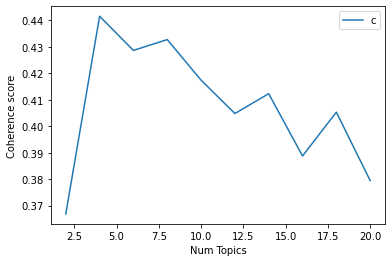

In [67]:
# Show graph
limit=22; start=2; step=2;
x = range(start, limit, step)
print(len(coherence_values))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [68]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3669
Num Topics = 4  has Coherence Value of 0.4416
Num Topics = 6  has Coherence Value of 0.4287
Num Topics = 8  has Coherence Value of 0.4328
Num Topics = 10  has Coherence Value of 0.4174
Num Topics = 12  has Coherence Value of 0.4048
Num Topics = 14  has Coherence Value of 0.4123
Num Topics = 16  has Coherence Value of 0.3888
Num Topics = 18  has Coherence Value of 0.4053
Num Topics = 20  has Coherence Value of 0.3795


In [69]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.021*"frontero" + 0.019*"mexico" + 0.017*"compartir" + 0.015*"hoy" + '
  '0.014*"necesitar" + 0.012*"hablar" + 0.012*"ayudar" + 0.011*"querer" + '
  '0.011*"salir" + 0.010*"ano"'),
 (1,
  '0.013*"venezolano" + 0.007*"cubano" + 0.007*"votar" + 0.007*"decir" + '
  '0.007*"estadounidense" + 0.006*"presidente" + 0.006*"ciudad" + '
  '0.006*"poblar" + 0.006*"migrante" + 0.006*"frontero"'),
 (2,
  '0.052*"inmigrante" + 0.030*"ley" + 0.026*"visar" + 0.026*"familiar" + '
  '0.018*"noticiar" + 0.018*"procesar" + 0.017*"unir" + 0.015*"programar" + '
  '0.015*"migratorio" + 0.013*"ano"'),
 (3,
  '0.059*"legal" + 0.032*"abogar" + 0.031*"inmigracion" + 0.027*"asilar" + '
  '0.023*"casar" + 0.020*"trabajar" + 0.019*"tramitar" + 0.016*"formulario" + '
  '0.013*"derecho" + 0.013*"dar"'),
 (4,
  '0.035*"trump" + 0.019*"nuevo" + 0.017*"indocumentado" + 0.013*"octubre" + '
  '0.012*"caso" + 0.011*"tarifar" + 0.010*"daca" + 0.010*"decir" + '
  '0.009*"personar" + 0.008*"coronavirus"'),
 (5,
  '0.

## Finding the dominant topic in each sentence

In [70]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.1949,"legal, abogar, inmigracion, asilar, casar, trabajar, tramitar, formulario, derecho, dar","Soy un refugiado o asilado: ¿Puedo trabajar ? Migración Soy un refugiado o asilado: ¿Puedo trabajar ? Por Primera Línea - agosto 25, 2020 0 18 Facebook Twitter WhatsApp ¿Cómo demuestro que estoy autorizado para trabajar en los Estados Unidos? Como refugiado, puede trabajar inmediatamente después de llegar a los Estados Unidos. Cuando se l... Soy un refugiado o asilado: ¿Puedo trabajar ? | Prim..."
1,1,6.0,0.4440,"poder, hacer, solo, familia, pasar, tiempo, vida, ninos, gran, post","Hoy queremos felicitar a una gran estudiante quien cumplió su sueño de obtener la licencia de conducir con la mejor escuela del estado de New York, LATINOS DRIVING SCHOOL, LA RUTA DIRECTA A TUS SUEÑOS... Para nosotros es muy importante cumplir cada paso junto a cada estudiante para poder verles la felicidad a cada uno y poder retratarlos en nuestras mentes y en nuestros corazon, con el mismo c..."
2,2,6.0,0.1856,"poder, hacer, solo, familia, pasar, tiempo, vida, ninos, gran, post",SELLO DE EMIGRACIÓN EN COLOMBIA !! 🔆 Nos recibirá un gran aroma de cafe con el nuevo selló de Emigracion para muchos será una bienvenida a sus recuerdos y para otros a un mundo que nos reconoce internacionalmente . #Colombia Festival Independencia Orgullo Colombiano
3,3,4.0,0.3395,"trump, nuevo, indocumentado, octubre, caso, tarifar, daca, decir, personar, coronavirus","Con un contundente discurso en el que prometió poner fin a un largo periodo de oscuridad, el ex-VP #JoeBiden acepta oficialmente la nominación presidencial demócrata. De cara a las elecciones de noviembre, el Pdte. Donald #Trump continúa con su promesa de construir un muro en la frontera con #México. El mando de #FortHood pide la ayuda del público para dar con el paradero de otro soldado desap..."
4,4,5.0,0.2118,"abogar, preguntar, consultar, hora, citar, hoy, vivir, primero, recordar, llamar","LATINOS DRIVING SCHOOL, LA RUTA DIRECTA A TUS SUEÑOS, desea invitarlos y a compartir con nosotros de nuestras clases de 5 horas online; Porque son importantes estas clases? tomando en cuenta la situación de salubridad actual debemos tomar medidas que nos permitan que cada uno de ustedes puedan aprender de una manera segura, pero ademas es una herramienta potente y efectiva para la interacción..."
5,5,5.0,0.2087,"abogar, preguntar, consultar, hora, citar, hoy, vivir, primero, recordar, llamar","LATINOS DRIVING SCHOOL, LA RUTA DIRECTA A TUS SUEÑOS, desea invitarlos y a compartir con nosotros de nuestras clases de 5 horas online; Porque son importantes estas clases? tomando en cuenta la situación de salubridad actual debemos tomar medidas que nos permitan que cada uno de ustedes puedan aprender de una manera segura, pero ademas es una herramienta potente y efectiva para la interacción..."
6,6,3.0,0.1891,"legal, abogar, inmigracion, asilar, casar, trabajar, tramitar, formulario, derecho, dar","Desde el momento en que reciba su documento de autorización de trabajo, es especialmente importante tener en cuenta la fecha de vencimiento. Teniendo en cuenta la cantidad de semanas que se necesitan para renovar este documento, no adelantar el trámite de renovación con suficiente anticipación podría generar retrasos, lo que puede poner al solicitante en una situación difícil, financiera y le..."
7,7,6.0,0.1835,"poder, hacer, solo, familia, pasar, tiempo, vida, ninos, gran, post","""Este es un mercado laboral que se nutre de salarios baratos y la mayoría de estos trabajadores son indocumentados"". Agregó que los trabajadores indocumentados son ""extremadamente vulnerables, y los empleadores se aprovechan de ellos"". Más de 20 Años Luchando Por Los Trabajadores Lesionados. Visítanos www.unionlawyer.com 100-15 Queens Boulevard Suite 203. Forest Hills NY 11375 Llama 718-897-22..."
8,8,6.0,0.1537,"poder, hacer, solo, familia, pasar, tiempo, vida, ninos, gran, post","La mú

## Find the most representative document for each topic

In [71]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7685,"frontero, mexico, compartir, hoy, necesitar, hablar, ayudar, querer, salir, ano","Para quienes odian 🇺🇸 USA 🇺🇸 Una verdad valedera e irrefutable sobre el mal llamado Imperio de los Gringos. Yo sé que los gringos son como son, pero como decía un tío mío, son los únicos que han llegado a la luna y eso deberíamos de tomarlo en cuenta, y pongan atención a las palabras de Abraham Lincoln hace 150 años (más abajo). Los invito a leer este mensaje desde la serenidad y la inteligenc..."
1,1.0,0.7613,"venezolano, cubano, votar, decir, estadounidense, presidente, ciudad, poblar, migrante, frontero","EEUU INCREMENTA PRESIÓN CONTRA DICTADURA VENEZOLANA Por Agencia EFE (19 septiembre 2020) 🔴 El jefe de la diplomacia estadounidense, Mike Pompeo, concluyó este sábado una gira de tres días en países vecinos de Venezuela con el objetivo de incrementar la presión sobre el gobernante Nicolás Maduro, cuya influencia maligna en la región, dijo, “no puede ser tolerada”. Luego de visitar las flamantes..."
2,2.0,0.5997,"inmigrante, ley, visar, familiar, noticiar, procesar, unir, programar, migratorio, ano","USCIS Actualiza Guías de Políticas sobre Peticiones de Visas O. . El Servicio de Ciudadanía e Inmigración de Estados Unidos publicó hoy una nueva sección (PDF, 296.54 KB) en el Manual de Políticas de USCIS relacionada con las clasificaciones de no inmigrantes O. El estatus de no inmigrante O-1 está disponible para extranjeros de “habilidades extraordinarias” en las ciencias, artes, educación,..."
3,3.0,0.7754,"legal, abogar, inmigracion, asilar, casar, trabajar, tramitar, formulario, derecho, dar","╚»★«╝ Como inmigrantes, usualmente nos encontramos en un terreno de dudas y desconocimiento frente al país en el que nos incorporamos🇺🇸🇺🇸, es una realidad, y si muchas veces no estás bien informado o desconoces completamente como funciona este, lo recomendable es buscar asesoría con los expertos. Adquirir tu seguro de salud a través de la Ley de Seguros de Salud a bajo costo, significa solicit..."
4,4.0,0.5702,"trump, nuevo, indocumentado, octubre, caso, tarifar, daca, decir, personar, coronavirus","#OREMOS UN RATITO Fortaléceme Señor, Acompáñame Señor, Protégeme Señor, Cúbreme con tu preciosisima sangre Señor, *Jesús, eres mi roca, mi escudo, mi fuerza, te amo, te necesito, protégeme del virus que nos amenaza, protege mis seres queridos y protege a toda la humanidad y sana a todos los que están enfermos.* Señor Jesús, unidos como hermanos te rogamos, que por tu misericordia infinita, no..."
5,5.0,0.7823,"abogar, preguntar, consultar, hora, citar, hoy, vivir, primero, recordar, llamar","Excelente promoción exclusiva para todas las personas que están fuera del país: Paquete de diplomados y formatos jurídicos online. Opciones de diplomados: DERECHO CIVIL, PENAL, LABORAL, LOPNNA, DERECHO AGRARIO, DERECHO MARÍTIMO, SUCESIONES, DERECHO MERCANTIL, COMPONENTE DOCENTE, RELACIONES INTERNACIONALES, DERECHO INTERNACIONAL, TRATA DE PERSONAS, RESPONSABILIDAD PENAL EN EL ADOLESCENTE, MIGRA..."
6,6.0,0.7167,"poder, hacer, solo, familia, pasar, tiempo, vida, ninos, gran, post","Comparto las palabras de uno de los realizadores cubanos más grandes dentro de la animación contemporánea Comparte esta publicación hacerla viral , vamos aportar nuestro granito de arena para que Victor Alfonso Cedeño pueda seguir luchando. ...(palabras de Víctor) Hoy no vengo a hacerles reír. Mi nombre es Victor Alfonso, soy el creador y director de las series de dibujos animados Dany y el C..."
7,7.0,0.7522,"hacer, servicio, partir, frontero, mejor, tambien, septiembre, contar, conocer, volar","Lema de Havana Gardens: ‘No es lo mismo servir por interés, que interés por servir,’ Aforismo del día: ‘La felicidad es ausencia de miedo.’ Fotos de Cuba: Plazas públicas en Cuba. A día de hoy y producto de la pandemia que azota todo a toda La Isla, las plazas y parques cubanos están vacíos para evitar la propagación de la pandemia. Miren, en nues

In [72]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [73]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,3.0,"legal, abogar, inmigracion, asilar, casar, trabajar, tramitar, formulario, derecho, dar",1644.0,0.1719
1.0,6.0,"poder, hacer, solo, familia, pasar, tiempo, vida, ninos, gran, post",838.0,0.0876
2.0,6.0,"poder, hacer, solo, familia, pasar, tiempo, vida, ninos, gran, post",1030.0,0.1077
3.0,4.0,"trump, nuevo, indocumentado, octubre, caso, tarifar, daca, decir, personar, coronavirus",1050.0,0.1098
4.0,5.0,"abogar, preguntar, consultar, hora, citar, hoy, vivir, primero, recordar, llamar",1346.0,0.1408
5.0,5.0,"abogar, preguntar, consultar, hora, citar, hoy, vivir, primero, recordar, llamar",2071.0,0.2166
6.0,3.0,"legal, abogar, inmigracion, asilar, casar, trabajar, tramitar, formulario, derecho, dar",959.0,0.1003
7.0,6.0,"poder, hacer, solo, familia, pasar, tiempo, vida, ninos, gran, post",625.0,0.0654
